In [1]:
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


Bad key "text.kerning_factor" on line 4 in
/Users/chenyilu/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons or units per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        if self.n_hidden_layers != 0:
            self.input_layer = nn.Linear(self.input_dimension, self.neurons)
            self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers-1)])
            self.output_layer = nn.Linear(self.neurons, self.output_dimension)

        else:
            print("Simple linear regression")
            self.linear_regression_layer = nn.Linear(self.input_dimension, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        if self.n_hidden_layers != 0:
            x = self.activation(self.input_layer(x))
            for k, l in enumerate(self.hidden_layers):
                x = self.activation(l(x))
            return self.output_layer(x)
        else:
            return self.linear_regression_layer(x)

def NeuralNet_Seq(input_dimension, output_dimension, n_hidden_layers, neurons):
    modules = list()
    modules.append(nn.Linear(input_dimension, neurons))
    modules.append(nn.Tanh())
    for _ in range(n_hidden_layers):
        modules.append(nn.Linear(neurons, neurons))
        modules.append(nn.Tanh())
    modules.append(nn.Linear(neurons, output_dimension))
    model =  nn.Sequential(*modules)
    return model

In [3]:
import pandas as pd

In [4]:
data_training = pd.read_csv('TrainingData.txt',sep=',')
data_training = pd.DataFrame(data_training)

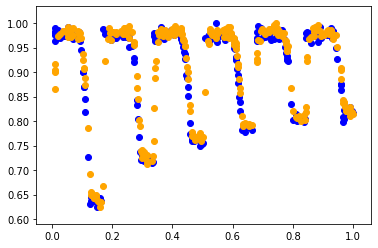

In [5]:
t = data_training["t"]
tf0 = data_training["tf0"]
ts0 = data_training["ts0"]
t_max = max(t)
tf0_max = max(tf0)
ts0_max = max(ts0)
t = t/t_max
tf0 = tf0/tf0_max
ts0 = ts0/ts0_max
plt.scatter(t, tf0, c="blue" )
plt.scatter(t, ts0, c="orange")
plt.show()

In [6]:
my_network_tf0 = NeuralNet(input_dimension=1, output_dimension=1, n_hidden_layers=10, neurons=10)
my_network_ts0 = NeuralNet(input_dimension=1, output_dimension=1, n_hidden_layers=10, neurons=10)

In [7]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
# Xavier weight initialization
init_xavier(my_network_tf0, 567)
init_xavier(my_network_ts0, 34)

In [8]:
opt_type = "LBFGS"
# Random Seed for dataset generation
# 567 34 134
sampling_seed = 34
torch.manual_seed(sampling_seed)

In [9]:
opt_type = "LBFGS"
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network_tf0.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_tf0 = optim.LBFGS(my_network_tf0.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
    optimizer_ts0 = optim.LBFGS(my_network_ts0.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [10]:
def fit(model, training_set, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):  
            
            def closure():
                
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                # Item 1. above
                loss = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, ))**p)
                # Item 2. above
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                #for param in model.parameters():
                #    print(param.shape)
                #    print(param.grad)
                return loss
            
            # Item 3. above
            optimizer.step(closure=closure)
            
        if verbose: print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history

In [11]:

batch_size = tf0.shape[0]
t = torch.from_numpy(t.values.reshape(-1,1)).float()
tf0 = torch.from_numpy(tf0.values.reshape(-1,1)).float()
ts0 = torch.from_numpy(ts0.values.reshape(-1,1)).float()
training_set_tf0 = DataLoader(torch.utils.data.TensorDataset(t, tf0), batch_size= batch_size, shuffle = True)
training_set_ts0 = DataLoader(torch.utils.data.TensorDataset(t, ts0), batch_size= batch_size, shuffle = True)
type(t)

torch.Tensor

In [12]:
n_epochs = 5000

tf0_history = fit(my_network_tf0, training_set_tf0, n_epochs, optimizer_tf0, p=2, verbose=False)
ts0_history = fit(my_network_ts0, training_set_ts0, n_epochs, optimizer_ts0, p=2, verbose=False)

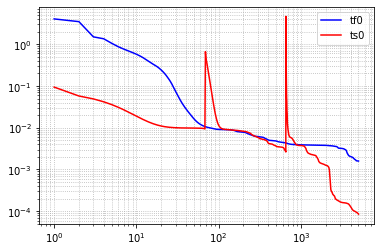

In [13]:
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1,n_epochs+1), tf0_history, c="Blue", label="tf0")
plt.plot(np.arange(1,n_epochs+1), ts0_history, c="Red", label="ts0")
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [14]:
type(t)

torch.Tensor

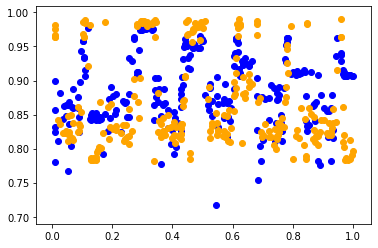

In [15]:

plt.scatter(t.detach(),my_network_tf0(tf0).detach(), c="blue")
plt.scatter(t.detach(),my_network_ts0(ts0).detach(), c="orange")
plt.show()

In [16]:
data_testing = pd.read_csv('TestingData.txt',sep=',')
data_testing = pd.DataFrame(data_testing)
t_test = data_testing["t"]

In [17]:
tf0_test_pred_tensor = my_network_tf0(torch.from_numpy(t_test.values.reshape(-1,1)).float()).reshape(-1,)
print(type(tf0_test_pred_tensor))
tf0_test_pred = tf0_test_pred_tensor.detach().numpy()
print(type(tf0_test_pred))

<class 'torch.Tensor'>
<class 'numpy.ndarray'>


In [18]:
ts0_test_pred_tensor = my_network_ts0(torch.from_numpy(t_test.values.reshape(-1,1)).float()).reshape(-1,)
print(type(tf0_test_pred_tensor))
ts0_test_pred = ts0_test_pred_tensor.detach().numpy()
print(type(ts0_test_pred))

<class 'torch.Tensor'>
<class 'numpy.ndarray'>


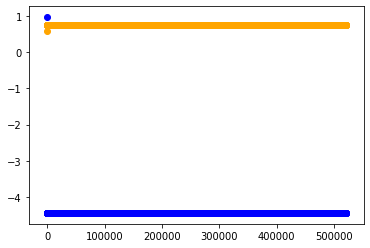

In [19]:
plt.scatter(t_test, tf0_test_pred, c="blue")
plt.scatter(t_test, ts0_test_pred, c="orange")
plt.show()